# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report. 
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pandas as pd

torch.manual_seed(1)
np.random.seed(5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using following device: {device}')

Using following device: cuda


In [4]:
# Importing data
BATCH_SIZE = 32

# Convert data to PyTorch tensor form and normalise it
# The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

## download and load training dataset
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

## download and load test set
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Let's see what we're working on by plotting a sample of our data

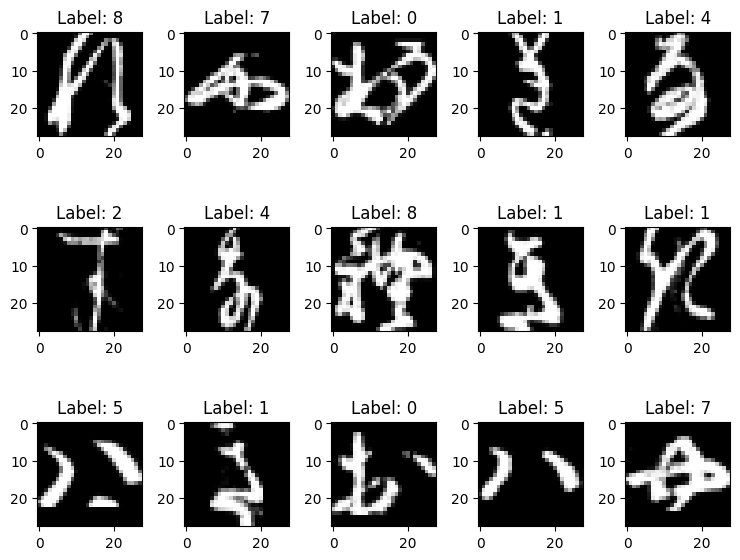

In [3]:
num_row = 3
num_col = 5

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(trainset.targets[i]))
plt.tight_layout()
plt.show()

In [4]:
# printing data shapes to get an idea of what we will work with
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break
print("Unique labels in the dataset:", trainset.targets.unique())

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
Unique labels in the dataset: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


Let's get to the training steps:
first we define our models, then some functions used to train the models

In [5]:
class FCNN_v1(nn.Module):
    '''
    Simple fully connected neural network with one hidden layer
    '''
    def __init__(self):
        super(FCNN_v1, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(in_features= 28*28, out_features=256)
        self.l2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

class FCNN_v2(nn.Module):
    '''
    Fully connected neural network with two hidden layers
    '''
    def __init__(self):
        super(FCNN_v2, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(in_features= 28*28, out_features=256)
        self.l2 = nn.Linear(in_features= 256, out_features=128)
        self.l3 = nn.Linear(in_features= 128, out_features=64)
        self.l4 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return self.l4(x)

class CNN_v0(nn.Module):
    """
    CNN with one hidden layer
    """
    def __init__(self):
        super(CNN_v0, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3)
        self.l1 = nn.Linear(64 * 12 * 12, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.flatten(start_dim = 1)
        return self.l1(x)

class CNN_v1(nn.Module):
    """
    CNN with two hidden convolutional layers
    """
    def __init__(self):
        super(CNN_v1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.l1 = nn.Linear(64 * 24 * 24, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.flatten(start_dim = 1)
        return self.l1(x)

class CNN_v2(nn.Module):
    """
    CNN with two convolutional layers and pooling
    """
    def __init__(self):
        super(CNN_v2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.l1 = nn.Linear(64 * 14 * 14, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.flatten(start_dim=1)
        return self.l1(x)

class CNN_v3(nn.Module):
    """
    variant of CNN_v3, pooling is applied before the convolutional layers
    """
    def __init__(self):
        super(CNN_v3, self).__init__()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.l1 = nn.Linear(64 * 14 * 14, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = x.flatten(start_dim=1)
        return self.l1(x)


In [6]:
# auxiliary functions

def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

def compute_weight_norm(model):
    norm = 0.0
    for name, param in model.named_parameters():
      if "weight" in name:
        norm += torch.norm(param.data, p= 2)
    return norm.cpu().item()

def train_model(model, num_epochs, trainloader, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    losses = []
    accs = []
    norms = []
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        # Set the model to training mode
        model = model.train()
        start = time()

        ## training steps
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)
            # Reset the gradients to zero
            optimizer.zero_grad()
            loss.backward()
            ## update model params
            optimizer.step()
            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)

        losses.append(train_running_loss / i)
        accs.append(train_acc/i)
        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")
        
    return losses, accs, norms

Now it's time to train and test the models

In [7]:
results_list = []
for model_class in [FCNN_v1, FCNN_v2, CNN_v1, CNN_v2, CNN_v3]: 
    for optimizer_class in [torch.optim.Adam, torch.optim.SGD]:
        for lr in [0.002, 0.02]:
            print(f'    Training {model_class.__name__} with {optimizer_class.__name__} and learning rate {lr}')
            model = model_class()
            optimizer = optimizer_class(model.parameters(), lr=lr)
            losses, accs, norms = train_model(model=model, num_epochs=4, trainloader=trainloader, criterion=nn.CrossEntropyLoss(), optimizer=optimizer)

            # Evaluate the model on the test set
            model.eval()
            test_loss = 0.0
            test_acc = 0.0
            with torch.no_grad():
                for images, labels in testloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    logits = model(images)
                    loss = nn.CrossEntropyLoss()(logits, labels)
                    test_loss += loss.item()
                    test_acc += get_accuracy(logits, labels)
            print(f"    Test Loss: {test_loss / len(testloader):.4f} | Test Accuracy: {test_acc / len(testloader):.4f}\n")

            # Store the results in a dictionary
            results = {
                "Model": model_class.__name__,
                "Optimizer": optimizer_class.__name__,
                "Learning Rate": lr,
                "Train Accuracy": accs[-1],
                "Test Accuracy": test_acc / len(testloader)
            }

            # Append the results to a list
            results_list.append(results)

# Convert the results list to a pandas DataFrame and display it
results_df = pd.DataFrame(results_list)
display(results_df)


    Training FCNN_v1 with Adam and learning rate 0.002
Epoch: 1 | Loss: 0.3315 | Train Accuracy: 89.8996 | Time: 24.36
Epoch: 2 | Loss: 0.1487 | Train Accuracy: 95.5526 | Time: 22.96
Epoch: 3 | Loss: 0.0996 | Train Accuracy: 97.0151 | Time: 24.30
Epoch: 4 | Loss: 0.0737 | Train Accuracy: 97.7738 | Time: 27.51
    Test Loss: 0.4238 | Test Accuracy: 89.8063

    Training FCNN_v1 with Adam and learning rate 0.02
Epoch: 1 | Loss: 0.5704 | Train Accuracy: 84.2483 | Time: 26.48
Epoch: 2 | Loss: 0.4718 | Train Accuracy: 88.0470 | Time: 25.58
Epoch: 3 | Loss: 0.4496 | Train Accuracy: 88.8207 | Time: 26.43
Epoch: 4 | Loss: 0.4363 | Train Accuracy: 89.1425 | Time: 18.65
    Test Loss: 0.9971 | Test Accuracy: 75.8886

    Training FCNN_v1 with SGD and learning rate 0.002
Epoch: 1 | Loss: 1.8719 | Train Accuracy: 53.3918 | Time: 14.36
Epoch: 2 | Loss: 1.1761 | Train Accuracy: 71.4431 | Time: 15.80


KeyboardInterrupt: 

Now let's focus on model CNN_v2 and see how losses and accuracy of train and test relate to eachother across epochs

In [7]:
def train_model_v2(model, num_epochs, trainloader, criterion, optimizer):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_l = []
    test_l = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        # Set the model to training mode
        model = model.train()
        start = time()

        ## training steps
        for i, (images, labels) in enumerate(trainloader):
            images = images.to(device)
            labels = labels.to(device)
            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)
            # Reset the gradients to zero
            optimizer.zero_grad()
            loss.backward()
            # update model params
            optimizer.step()
            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)

        train_l.append(train_running_loss / i)
        train_accs.append(train_acc/i)

        # Compute performance on test set at the end of every epoch
        model.eval()
        test_loss = 0.0
        test_acc = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                logits = model(images)
                loss = nn.CrossEntropyLoss()(logits, labels)
                test_loss += loss.item()
                test_acc += get_accuracy(logits, labels)
        test_l.append(test_loss / len(testloader))
        test_accs.append(test_acc / len(testloader))

    return train_l, test_l, train_accs, test_accs

In [9]:
model = CNN_v2()
# train_l_all = []
# test_l_all = []
# train_accs_all = []
# test_accs_all = []

# for _ in range(3):  # Perform N trainings
#     train_l, test_l, train_accs, test_accs = train_model_v2(model=model, num_epochs=6, trainloader=trainloader, criterion=nn.CrossEntropyLoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.002))
#     train_l_all.append(train_l)
#     test_l_all.append(test_l)
#     train_accs_all.append(train_accs)
#     test_accs_all.append(test_accs)

# # Average the results over 5 trainings
# train_l_avg = np.mean(train_l_all, axis=0)
# test_l_avg = np.mean(test_l_all, axis=0)
# train_accs_avg = np.mean(train_accs_all, axis=0)
# test_accs_avg = np.mean(test_accs_all, axis=0)

# train_l, test_l, train_accs, test_accs = train_l_avg, test_l_avg, train_accs_avg, test_accs_avg

train_l, test_l, train_accs, test_accs = train_model_v2(model=model, num_epochs=6, trainloader=trainloader, criterion=nn.CrossEntropyLoss(), optimizer=torch.optim.Adam(model.parameters(), lr=0.002))

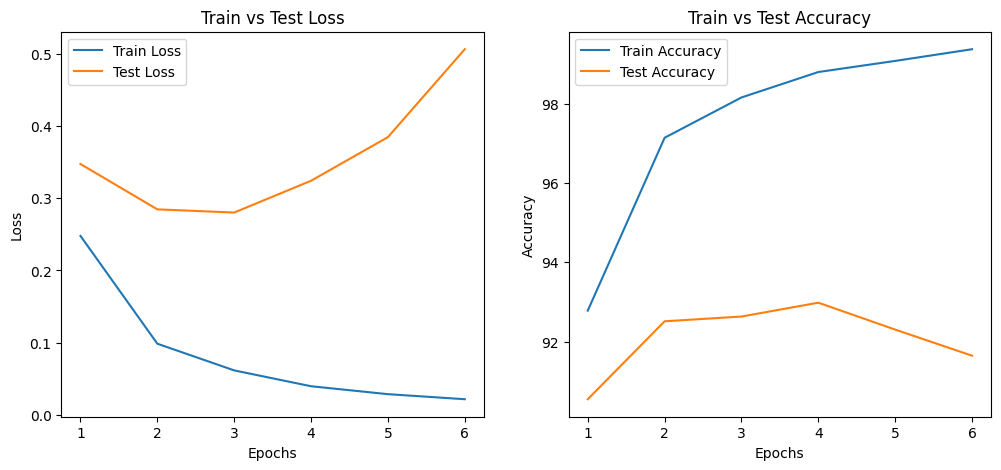

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot train losses vs test losses
ax[0].plot(range(1, len(train_l) + 1), train_l, label='Train Loss')
ax[0].plot(range(1, len(test_l) + 1), test_l, label='Test Loss')
ax[0].set_title('Train vs Test Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot train accuracy vs test accuracy
ax[1].plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
ax[1].plot(range(1, len(test_accs) + 1), test_accs, label='Test Accuracy')
ax[1].set_title('Train vs Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

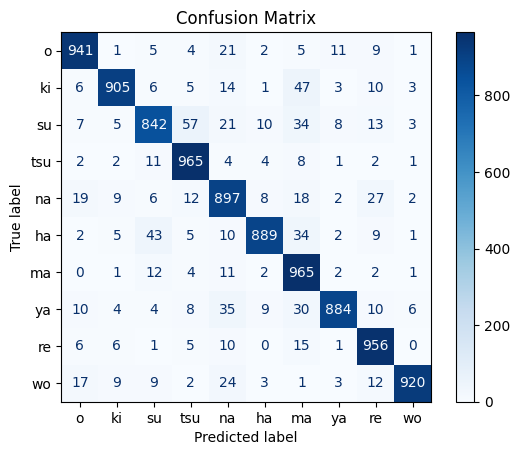

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set the model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=testset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Let's also consider per class accuracy

In [17]:
from collections import defaultdict
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

def evaluate_model_metrics(model, dataloader, device, class_names=None):
    model.eval()
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Per-class accuracy
            for label, pred in zip(labels, predicted):
                class_total[label.item()] += 1
                if label == pred:
                    class_correct[label.item()] += 1

    # Overall accuracy
    overall_accuracy = correct / total

    # Per-class accuracy
    num_classes = max(class_total.keys()) + 1
    per_class_accuracy = {}
    for i in range(num_classes):
        if class_total[i] > 0:
            per_class_accuracy[i] = class_correct[i] / class_total[i]
        else:
            per_class_accuracy[i] = None

    # Precision, Recall, F1
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)

    return {
        "overall_accuracy": overall_accuracy,
        "per_class_accuracy": per_class_accuracy,
        "macro_f1": f1,
        "macro_precision": precision,
        "macro_recall": recall,
        "classification_report": report
    }


def visualize_model_metrics(metrics, all_labels, all_preds, class_names):
    # 1. Per-class Accuracy
    acc_values = [metrics['per_class_accuracy'][i] if metrics['per_class_accuracy'][i] is not None else 0.0 for i in range(len(class_names))]
    
    plt.figure(figsize=(10, 4))
    plt.bar(class_names, acc_values, color='skyblue')
    plt.ylim(0, 1)
    plt.title("Per-Class Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Class")
    plt.grid(True, axis='y')
    plt.show()

    # 2. Per-class F1 Score
    from sklearn.metrics import f1_score
    f1_scores = f1_score(all_labels, all_preds, average=None)
    
    plt.figure(figsize=(10, 4))
    plt.bar(class_names, f1_scores, color='salmon')
    plt.ylim(0, 1)
    plt.title("Per-Class F1 Score")
    plt.ylabel("F1 Score")
    plt.xlabel("Class")
    plt.grid(True, axis='y')
    plt.show()

    # 3. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # 4. Print Macro Metrics
    print(f"Overall Accuracy: {metrics['overall_accuracy']:.2%}")
    print(f"Macro F1 Score: {metrics['macro_f1']:.2f}")
    print(f"Macro Precision: {metrics['macro_precision']:.2f}")
    print(f"Macro Recall: {metrics['macro_recall']:.2f}")


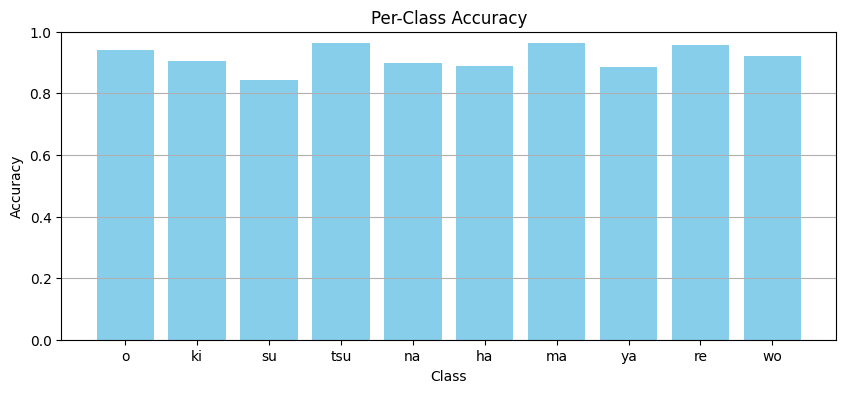

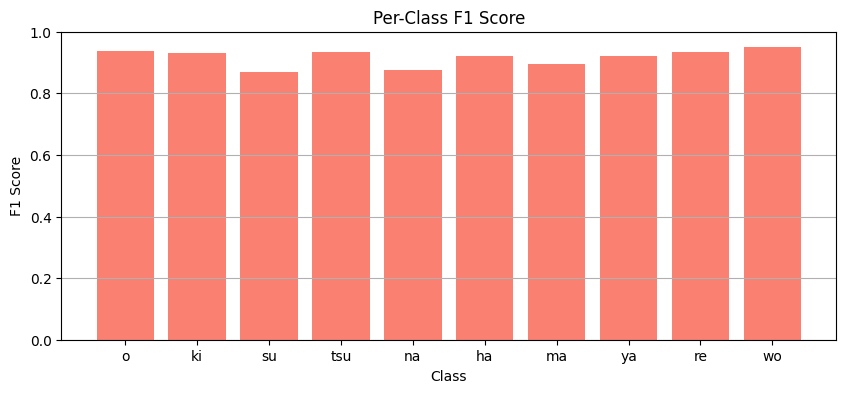

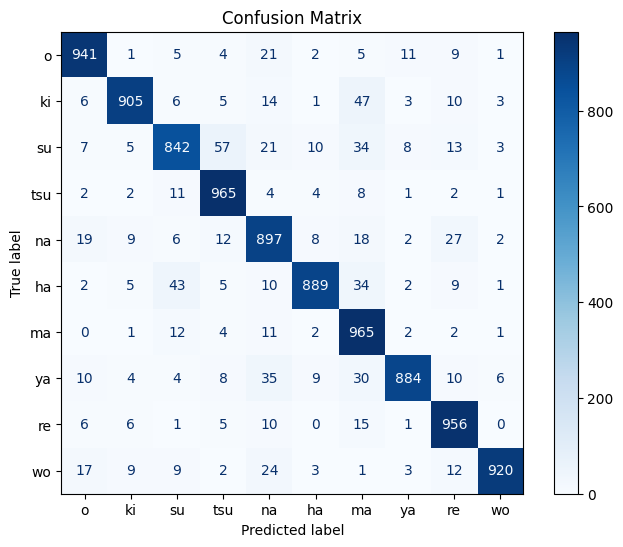

Overall Accuracy: 91.64%
Macro F1 Score: 0.92
Macro Precision: 0.92
Macro Recall: 0.92


In [16]:
device = 'cuda'
class_names = ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

res = evaluate_model_metrics(model, testloader, device, class_names)
visualize_model_metrics(res, all_labels, all_preds, class_names)